# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import session_info

In [2]:
try:
    session_info_output = session_info.show()
except Exception as error:
    print("The session info has been requested already:")
    
session_info_output

In [3]:
import janitor # This library generates an error when I execute session_info()

# Import external files

- Extension of the "missing" functions from Pandas
- DataFrame and dictionary functions
- Statistical functions

In [4]:
%run utils/u.0.0-pandas_missing_extension.ipynb
%run utils/u.0.1-df_functions.ipynb
%run utils/u.0.2-statistical-functions.ipynb

/home/ubuntu/anaconda3/lib/python3.11/site-packages/upsetplot/plotting.py:15: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


# Get the processed data

In [5]:
arg_di_df = pd.read_csv('../data/processed/WDICSV_PROCESSED.csv').clean_names(case_type="snake")

print(arg_di_df.shape)
arg_di_df.info()

(54, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    54 non-null     int64  
 1   it_mlt_main             54 non-null     float64
 2   ny_gdp_mktp_kd_zg       54 non-null     float64
 3   ny_gdp_pcap_kd          54 non-null     float64
 4   ny_gdp_pcap_kd_zg       54 non-null     float64
 5   sp_dyn_le00_in          53 non-null     float64
 6   it_cel_sets             50 non-null     float64
 7   sh_dth_imrt             53 non-null     float64
 8   sp_pop_0014_to_zs       54 non-null     float64
 9   sp_pop_1564_to_zs       54 non-null     float64
 10  sp_pop_65_up_to_zs      54 non-null     float64
 11  sp_pop_totl             54 non-null     float64
 12  sm_pop_refg             54 non-null     float64
 13  sm_pop_refg_or          44 non-null     float64
 14  se_pre_enrr             45 non-null

# Get columns names and types

In [6]:
indicators_names, categorical_cols, numeric_cols, columns_with_missing_values = get_columns(arg_di_df)

In [7]:
print(f'Total Columns: {len(indicators_names)}')
print(f'Categorical Columns: {len(categorical_cols)}')
print(f'Numeric Columns: {len(numeric_cols)}')

Total Columns: 28
Categorical Columns: 6
Numeric Columns: 22


In [8]:
indicators_names

['year, Year',
 'it_mlt_main, Fixed telephone subscriptions',
 'ny_gdp_mktp_kd_zg, GDP growth (annual %)',
 'ny_gdp_pcap_kd, GDP per capita (constant 2015 US$)',
 'ny_gdp_pcap_kd_zg, GDP per capita growth (annual %)',
 'sp_dyn_le00_in, Life expectancy at birth, total (years)',
 'it_cel_sets, Mobile cellular subscriptions',
 'sh_dth_imrt, Number of infant deaths',
 'sp_pop_0014_to_zs, Population ages 0-14 (% of total population)',
 'sp_pop_1564_to_zs, Population ages 15-64 (% of total population)',
 'sp_pop_65_up_to_zs, Population ages 65 and above (% of total population)',
 'sp_pop_totl, Population, total',
 'sm_pop_refg, Refugee population by country or territory of asylum',
 'sm_pop_refg_or, Refugee population by country or territory of origin',
 'se_pre_enrr, School enrollment, preprimary (% gross)',
 'se_prm_enrr, School enrollment, primary (% gross)',
 'se_sec_enrr, School enrollment, secondary (% gross)',
 'se_ter_enrr, School enrollment, tertiary (% gross)',
 'sp_urb_totl_in_zs,

In [9]:
columns_with_missing_values

['se_ter_enrr',
 'sm_pop_refg_or',
 'se_pre_enrr',
 'se_prm_enrr',
 'se_sec_enrr',
 'it_cel_sets',
 'it_cel_sets_pct',
 'sp_dyn_le00_in',
 'sh_dth_imrt']

# Shadow matrix

In [10]:
shadow_matrix = arg_di_df.missing.bind_shadow_matrix(only_missing = True, true_string="Missing", false_string="Not Missing")
shadow_matrix.head()

,year,it_mlt_main,ny_gdp_mktp_kd_zg,ny_gdp_pcap_kd,ny_gdp_pcap_kd_zg,sp_dyn_le00_in,it_cel_sets,sh_dth_imrt,sp_pop_0014_to_zs,sp_pop_1564_to_zs,...,ny_gdp_mktp_kd_grw_cat,sp_dyn_le00_in_NA,it_cel_sets_NA,sh_dth_imrt_NA,sm_pop_refg_or_NA,se_pre_enrr_NA,se_prm_enrr_NA,se_sec_enrr_NA,se_ter_enrr_NA,it_cel_sets_pct_NA
0,1970,1287000.0,3.045643,9257.895572,1.443200,65.589,0.0,32198.0,29.717264,63.733577,...,Unknown,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
1,1971,1287000.0,5.658131,9628.037838,3.998125,65.541,NaN,32685.0,29.656449,63.671716,...,Unknown,Not Missing,Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Missing
2,1972,1287000.0,1.628417,9630.010366,0.020487,65.923,NaN,33079.0,29.630850,63.584961,...,Medium volatility,Not Missing,Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Missing
3,1973,1287000.0,2.811754,9739.416271,1.136093,66.323,NaN,33442.0,29.652649,63.453990,...,Low volatility,Not Missing,Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Missing
4,1974,1287000.0,5.533804,10105.049508,3.754160,66.563,NaN,33629.0,29.739299,63.260447,...,Low volatility,Not Missing,Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Missing


# Data imputation

## Imputation by mean

/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


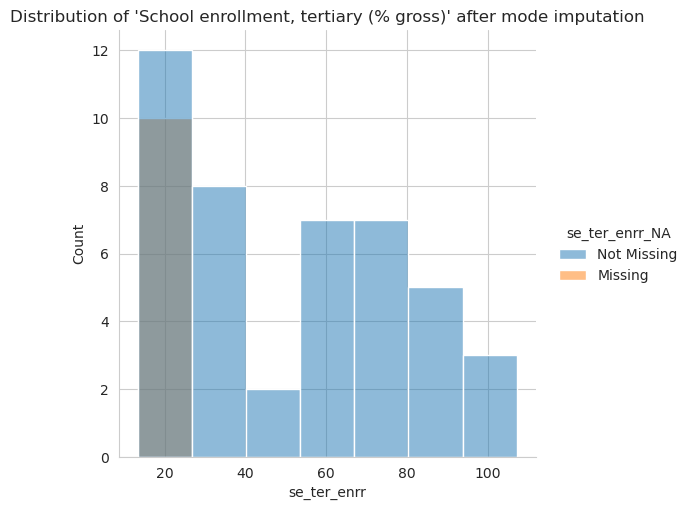

In [14]:
plot_imputation_by_statistic(shadow_matrix, columns_with_missing_values[0], "mode")

## Imputation by mean, median and mode

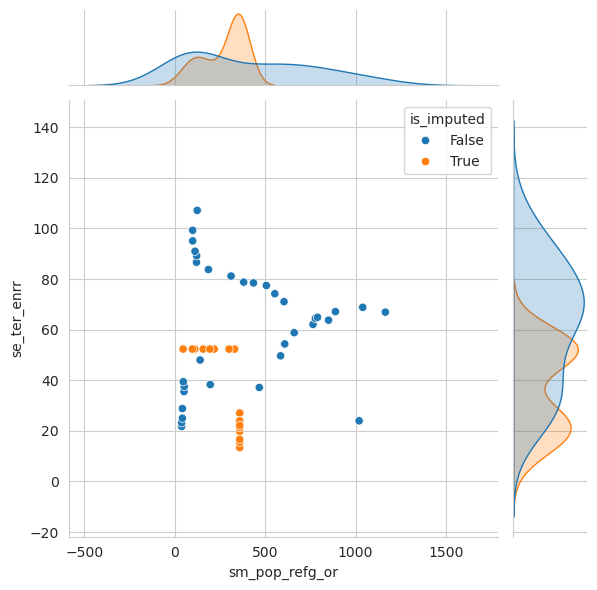

In [ ]:
arg_di_df_shadow_matrix.missing.scatter_imputation_plot(x=columns_with_missing_values[0], y=columns_with_missing_values[1],show_marginal=True)

## Imputation by interpolation

In [24]:
print(f"Quantity of missing values in {get_indicator_name('it_cel_sets',True)}: {arg_di_df['it_cel_sets'].isna().sum()}")

Quantity of missing values in Mobile cellular subscriptions: 4


In [26]:
arg_di_df[['year','it_cel_sets']].head(6)

,year,it_cel_sets
0,1970,0.0
1,1971,NaN
2,1972,NaN
3,1973,NaN
4,1974,NaN
5,1975,0.0


In [28]:
arg_di_df['it_cel_sets'] = arg_di_df['it_cel_sets'].ffill()
arg_di_df[['year','it_cel_sets']].head(6)

,year,it_cel_sets
0,1970,0.0
1,1971,0.0
2,1972,0.0
3,1973,0.0
4,1974,0.0
5,1975,0.0


Interpolation: Using ffill() and bfill()

In [41]:
arg_di_df_single_imputation[columns_with_missing_values[4] + "_ffill"] = arg_di_df_single_imputation[columns_with_missing_values[4]].ffill()
arg_di_df_single_imputation[columns_with_missing_values[4] + "_bfill"] = arg_di_df_single_imputation[columns_with_missing_values[4]].bfill()
arg_di_df_single_imputation[columns_with_missing_values[4] + "_linear"] = arg_di_df_single_imputation[columns_with_missing_values[4]].interpolate(method="linear")
arg_di_df_single_imputation[columns_with_missing_values[4] + "_quadratic"] = arg_di_df_single_imputation[columns_with_missing_values[4]].interpolate(method="quadratic")
arg_di_df_single_imputation[columns_with_missing_values[4] + "_nearest"] = arg_di_df_single_imputation[columns_with_missing_values[4]].interpolate(method="nearest")

arg_di_df_single_imputation[arg_di_df_single_imputation[columns_with_missing_values[4]].isna()][[columns_with_missing_values[4],
                             columns_with_missing_values[4] + "_ffill",
                             columns_with_missing_values[4] + "_linear",
                            columns_with_missing_values[4] + "_quadratic",
                            columns_with_missing_values[4] + "_nearest",
                             columns_with_missing_values[4] + "_bfill"]]

,se_sec_enrr,se_sec_enrr_ffill,se_sec_enrr_linear,se_sec_enrr_quadratic,se_sec_enrr_nearest,se_sec_enrr_bfill
19,NaN,70.398979,71.403599,71.209666,70.398979,72.408218
22,NaN,73.748077,72.860906,72.857505,73.748077,71.086563
23,NaN,73.748077,71.973735,70.217585,71.086563,71.086563
25,NaN,71.086563,75.031483,76.340813,71.086563,78.976402
52,NaN,116.559448,116.559448,NaN,NaN,NaN
53,NaN,116.559448,116.559448,NaN,NaN,NaN


(<Axes: >, <Axes: >)

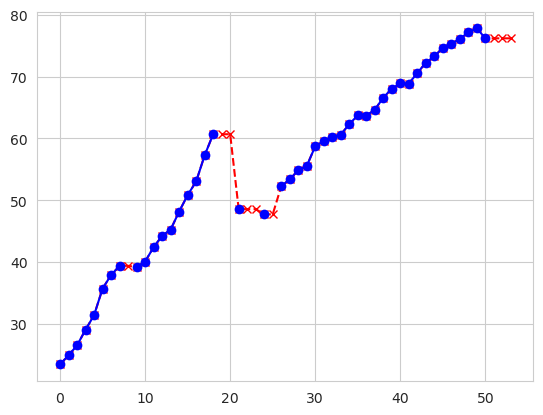

In [47]:
arg_di_df.pipe(
    lambda df: (
        df[columns_with_missing_values[2]].ffill().plot(color="red",marker="x",linestyle="dashed"),
        df[columns_with_missing_values[2]].plot(color="blue",marker="o")
   )
)

## Imputation by K-NN

For using this type of imputation, you must sort the variables by missingness

In [ ]:
knn_imputer = sklearn.impute.KNNImputer()

arg_di_df_knn = arg_di_df_transformed.missing.sort_variables_by_missingness(ascending=True).copy()
arg_di_df_knn.iloc[:,:] = knn_imputer.fit_transform(arg_di_df_knn)
arg_di_df_knn.head(5)

/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/numpy/ma/extras.py:617: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scl = avg.dtype.type(a.count(axis))
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/numpy/ma/extras.py:617: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scl = avg.dtype.type(a.count(axis))
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/numpy/ma/extras.py:617: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perf

,ny_gdp_mktp_kd_zg_cat,sp_pop_00_up_to_zs,year_of_dictatorship,sp_urb_totl_in_zs,sp_rur_totl_zs,sm_pop_refg,sp_pop_totl,sp_pop_65_up_to_zs,sp_pop_1564_to_zs,sp_totl_zs,...,sp_dyn_le00_in,sh_dth_imrt,sp_dyn_le00_in_cat,it_cel_sets,sh_dth_mort,se_sec_enrr,se_prm_enrr,se_pre_enrr,sm_pop_refg_or,se_ter_enrr
0,2.0,100.0,1.0,78.88,21.12,35000.0,23842803.0,6.549159,63.733577,100.0,...,65.589,32198.0,1.0,0.0,34598.0,44.709621,105.769478,23.44487,308.6,13.37759
1,0.0,100.0,1.0,79.321,20.679,34000.0,24223379.0,6.671836,63.671716,100.0,...,65.541,32685.0,1.0,2400.0,34598.0,45.642109,106.752098,24.93766,308.6,15.44098
2,1.0,100.0,1.0,79.743,20.257,33000.0,24612794.0,6.784189,63.584961,100.0,...,65.923,33079.0,1.0,2400.0,34598.0,47.47271,106.286819,26.51997,308.6,16.62081
3,2.0,100.0,1.0,80.158,19.842,37000.0,25020588.0,6.893361,63.45399,100.0,...,66.323,33442.0,1.0,2400.0,34598.0,49.939709,105.710747,29.06558,308.6,19.751631
4,0.0,100.0,0.0,80.567,19.433,47000.0,25449754.0,7.000254,63.260447,100.0,...,66.563,33629.0,1.0,2400.0,40082.0,52.76239,106.127319,31.40225,308.6,22.883011
5,3.0,100.0,0.0,80.969,19.031,46000.0,25875558.0,7.112786,63.02713,100.0,...,67.081,33434.0,1.0,0.0,39640.0,54.38755,105.47226,35.701939,308.6,27.07716
6,3.0,100.0,1.0,81.366,18.634,41010.0,26290257.0,7.230755,62.762791,100.0,...,67.228,32686.0,1.0,0.0,38536.0,55.880482,105.146507,37.910751,308.6,27.01174
7,0.0,100.0,1.0,81.755,18.245,35000.0,26713780.0,7.353308,62.479922,100.0,...,67.861,31346.0,1.0,0.0,36750.0,55.626678,105.946831,39.397282,308.6,23.964741
8,3.0,100.0,1.0,82.139,17.861,26390.0,27146121.0,7.479966,62.194376,100.0,...,68.197,29499.0,1.0,0.0,34382.0,55.343731,105.351021,37.730635,308.6,21.250999
9,0.0,100.0,1.0,82.516,17.484,27050.0,27584134.0,7.59906,61.914028,100.0,...,68.491,27357.0,1.0,0.0,31734.0,54.96629,105.662491,39.189339,74.0,22.12047


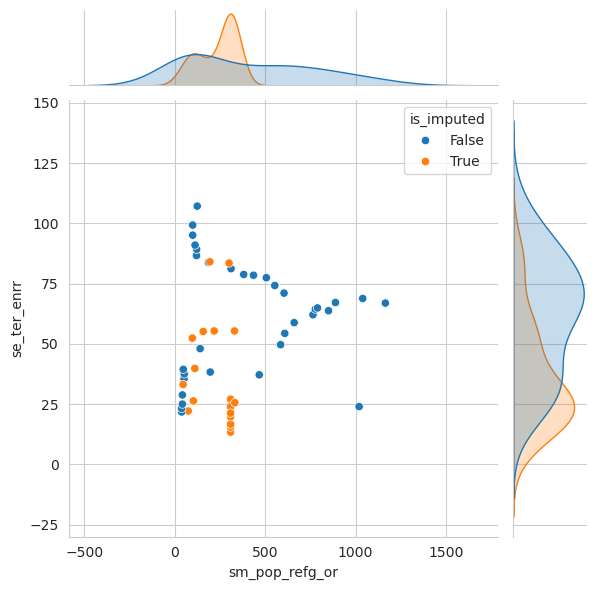

In [ ]:

(
    pd.concat(
        [
            arg_di_df_knn,
            arg_di_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x=columns_with_missing_values[0], y=columns_with_missing_values[1],show_marginal=True)
)

## Model Based Imputation

### Ordinary Least Squares (OLS)

In [ ]:
(
    smf.ols(
        formula="se_ter_enrr ~ se_pre_enrr + se_sec_enrr", # Regression formula: dependent variable (the variable being predicted) ~ independent variables
        data = arg_di_df
    )
    .fit() # Computes the regression model based on the given data
    .summary() # Provides a detailed report of the regression results
    .tables[0] # Selects the first table from the summary, which contains high-level model details
)

Dep. Variable:,se_ter_enrr,R-squared:,0.959
Model:,OLS,Adj. R-squared:,0.957
Method:,Least Squares,F-statistic:,461.8
Date:,"Thu, 27 Mar 2025",Prob (F-statistic):,7.04e-28
Time:,21:59:46,Log-Likelihood:,-128.87
No. Observations:,42,AIC:,263.7
Df Residuals:,39,BIC:,269.0
Df Model:,2,,
Covariance Type:,nonrobust,,


In [ ]:
arg_di_df_model = (
    arg_di_df
        .select(columns=["se_ter_enrr", "se_pre_enrr", "se_sec_enrr", "year"])
        .sort_values(by="se_ter_enrr")
        .transform_column( #If a dependent variable has NA values, then they predict NA results
            "se_pre_enrr",
            lambda x: x.ffill(),
            elementwise = False
        )
        .transform_column(
            "se_sec_enrr",
            lambda x: x.ffill(),
            elementwise = False
        )
        .missing.bind_shadow_matrix(
            True,
            False,
            False,
            "_imp"
        )
)

arg_di_df_model.head()

,se_ter_enrr,se_pre_enrr,se_sec_enrr,year,se_ter_enrr_imp,se_pre_enrr_imp,se_sec_enrr_imp,year_imp
0,13.377590,23.44487,44.709621,1970,False,False,False,False
1,15.440980,24.93766,45.642109,1971,False,False,False,False
2,16.620810,26.51997,47.472710,1972,False,False,False,False
3,19.751631,29.06558,49.939709,1973,False,False,False,False
8,21.250999,29.06558,55.343731,1978,False,False,False,False


In [ ]:
se_ter_enrr_ols = (
    arg_di_df_model
        .pipe(
            lambda df: smf.ols(formula="se_ter_enrr ~ se_pre_enrr + se_sec_enrr", data = df)
        )
        .fit()
)

In [ ]:
ols_imputed_values = (
    arg_di_df_model
        .pipe(lambda df: df[df.se_ter_enrr.isna()])
        .pipe(lambda df: se_ter_enrr_ols.predict(df).round())
)

ols_imputed_values

18    44.0
19    44.0
20    46.0
22    46.0
23    46.0
25    46.0
26    49.0
27    46.0
52    46.0
53    46.0
dtype: float64

In [ ]:
arg_di_df_model.loc[arg_di_df_model["se_ter_enrr"].isna(), "se_ter_enrr"] = ols_imputed_values

<Figure size 2000x2000 with 0 Axes>

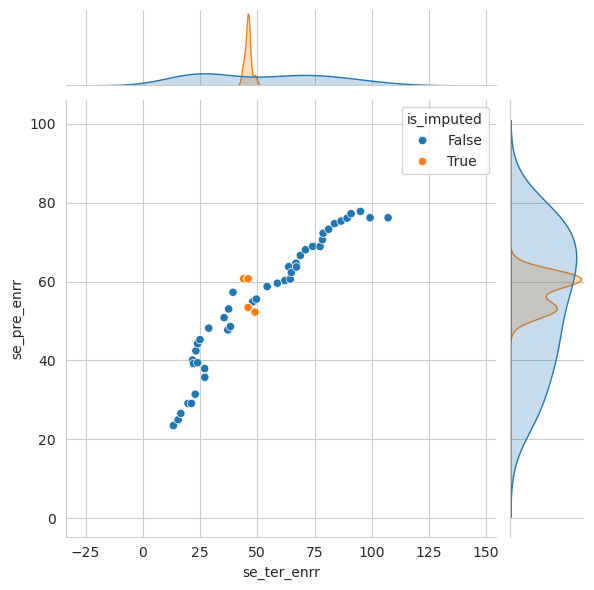

In [ ]:
plt.figure(figsize=(20,20))
arg_di_df_model.missing.scatter_imputation_plot(x="se_ter_enrr",y="se_pre_enrr",show_marginal=True)


## Multiple Imputation by Chained Equations (MICE)

It's a technique for imputing missing data, where multiple possible values are generated for each missing entry using iterative regression models.

By default, Scikit-Learn returns a single dataset, but this can be modified. You must provide values for all variables except the one you want to estimate.

<Axes: xlabel='sm_pop_refg_or', ylabel='se_ter_enrr'>

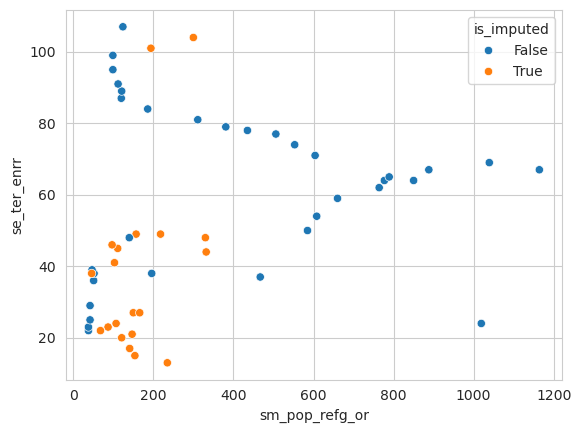

In [ ]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=BayesianRidge())

arg_di_df_mice = arg_di_df_transformed.copy()
arg_di_df_mice.iloc[:,:] = mice_imputer.fit_transform(arg_di_df_mice).round()

arg_di_df_mice = (
    pd.concat(
        [
            arg_di_df_mice,
            arg_di_df.missing.create_shadow_matrix(True,False,True,"_imp")
        ],
        axis=1
    )
)

arg_di_df_mice.missing.scatter_imputation_plot(
    x=columns_with_missing_values[0],
    y=columns_with_missing_values[1]
)

### Inverse transformation of data

In [ ]:
arg_di_df_imputated = arg_di_df_mice.copy()

arg_di_df_imputated[categorical_cols] = (
    categorical_transformer
        .named_transformers_.ordinalencoder.inverse_transform(
            X = arg_di_df_mice[categorical_cols]
        )
)

print(arg_di_df_mice.missing.number_missing())

pd.concat(
    [
        arg_di_df_mice[categorical_cols],
        arg_di_df_imputated[categorical_cols]
    ],
    axis=1
).head(5)

NameError: name 'arg_di_df_mice' is not defined

Source: https://deepnote.com/workspace/platzi-escuela-datos-83832097-f136-43ff-b38d-abaa022e8ec7/project/datos-faltantes-imputacion-bdf84ff9-f66c-44c7-a67c-ca1115a2b683/notebook/imputation-missing-values-60b90530690647e596864b472f71dfde

# Save the processed data

In [132]:
arg_di_df.to_csv('../data/processed/WDICSV_PROCESSED_V2.csv', index=False)

NameError: name 'arg_di_df_best_cases' is not defined